# TP classification de sons à rendre

Tom Bevan (tom.bevan@etu.unice.fr)
Vinh Faucher (vinh.faucher@etu.unice.fr)

Polytech SI3 - SSII - 2021-22

# Données



In [1]:
#les imports nécessaires pour la suite
import matplotlib.pyplot as plt
import numpy as np 
import glob
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.datasets import fetch_lfw_people
import cv2
from sklearn.model_selection import train_test_split

from sklearn import svm

## Les données
On va utiliser le jeu de données "lfw_people" en filtrant les classes contenant minimum 100 images.

In [2]:
lfw = fetch_lfw_people(min_faces_per_person=100, resize=1)
# à adapter selon l'ordinateur
verbose = True
taille_mfcc = 13
X = lfw.images
y = lfw.target
Xtrain, Xtest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=33)

# On crée les sifts

In [18]:
"""Définition des méthodes"""

def build_sifts_from_image_list(images, siftsRes, sifts_per_image=[]):

    """
    Remplit le numpy array sifts passé en paramètres avec les SIFTs de toutes les images.

    Arguments:
         images: une liste d'images, dont on souhaite calculer les SIFTs.
         siftsRes: le numpy array à remplir
         sifts_per_image: le tableau auquel on ajoute le nombre de SIFTs de chaque image.
    """

    for image in images:
        gray_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(gray_image, None)
        #print(siftsRes.shape)
        #print(des)
        siftsRes = np.append(siftsRes, des, axis=0)
        sifts_per_image.append(len(des))

    return siftsRes


sifts = np.empty(shape = (0, 128))
sifts_per_image = []

sifts = build_sifts_from_image_list(Xtrain, sifts, sifts_per_image)
#print(sifts.shape)

## Partitionnement en K-means

In [19]:
def build_clusters_list(sifts, k = 100):

    """
    Partitionne les SIFTs en k clusters et retourne le cluster auquel appartient chaque SIFT.

    Arguments:
        sifts: le numpy array de SIFTs à partitionner.
        k: le nombre de clusters souhaité.
    """

    kMeans = MiniBatchKMeans(n_clusters = k)
    kMeans.fit(sifts)
    return kMeans.labels_


def build_images_bows(labels, sifts_per_image, k = 100):

    """
    Construit un numpy array contenant les BOWs de chaque image.

    Arguments:
        labels: les labels de chaque SIFTs, CAD à quel cluster appartient chaque SIFT.
        sifts_per_image: le tableau décrivant le nombre de SIFT dans chaque image.
        k: le nombre de clusters.
    """

    all_bows = np.zeros(shape = (len(sifts_per_image), k))

    parcours = 0
    parcours_bis = 0
    for sift_amount in sifts_per_image:
        bow = np.zeros(k)
        for i in range(parcours + sift_amount):
            bow[labels[i]] += 1/sift_amount
        parcours += sift_amount
        all_bows[parcours_bis] = bow
        parcours_bis += 1

    return all_bows

In [20]:
"""Création des clusters"""

labels = build_clusters_list(sifts)

In [21]:
"""Construction des BOWs"""

bows = build_images_bows(labels, sifts_per_image)

In [22]:
"""Tests"""

print(labels)
print(bows.shape)
print(bows[0])
print(sum(bows[0]))

[89 14 50 ...  1 34 89]
(855, 100)
[0.         0.         0.         0.         0.         0.01886792
 0.         0.         0.         0.         0.         0.03773585
 0.01886792 0.         0.01886792 0.         0.         0.03773585
 0.01886792 0.05660377 0.01886792 0.         0.         0.01886792
 0.05660377 0.         0.         0.         0.         0.
 0.         0.05660377 0.         0.         0.03773585 0.03773585
 0.         0.         0.01886792 0.01886792 0.03773585 0.03773585
 0.         0.         0.         0.         0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.         0.         0.
 0.         0.         0.01886792 0.         0.         0.01886792
 0.         0.         0.01886792 0.         0.01886792 0.
 0.         0.         0.         0.         0.         0.03773585
 0.         0.01886792 0.01886792 0.         0.         0.
 0.         0.         0.         0.05660377 0.         0.
 0.         0.         0.01886792 0.01886792 0.         0.0754717
 

### Classification

In [23]:
"""Régression logistique puis classification"""

logisticRegr = LogisticRegression(max_iter = 100000)

scaler = preprocessing.StandardScaler().fit(bows)
xtrain = scaler.transform(bows)
logisticRegr.fit(xtrain, yTrain)

LogisticRegression(max_iter=100000)

In [24]:
ypred = logisticRegr.predict(xtrain)
print("train F1 score = ", f1_score(yTrain, ypred, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain, ypred))


train F1 score =  0.47719298245614034
train accuracy score =  0.47719298245614034


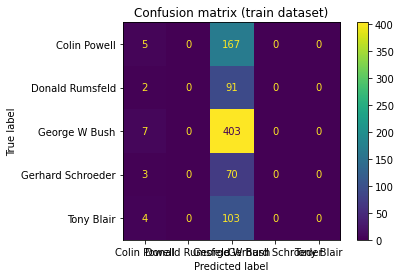

In [25]:
cm = confusion_matrix(yTrain, ypred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lfw.target_names)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')
plt.show()

In [26]:
sifts_test = np.empty(shape = (0, 128))
sifts_per_image_test = []

sifts_test = build_sifts_from_image_list(Xtest, sifts_test, sifts_per_image_test)

labels_test = build_clusters_list(sifts_test)

bows_test = build_images_bows(labels_test, sifts_per_image_test)




In [27]:
scaler = preprocessing.StandardScaler().fit(bows_test)
xtest = scaler.transform(bows_test)

ypred_test = logisticRegr.predict(xtest)
print("train F1 score = ", f1_score(yTest, ypred_test, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTest, ypred_test))


train F1 score =  0.42105263157894735
train accuracy score =  0.42105263157894735


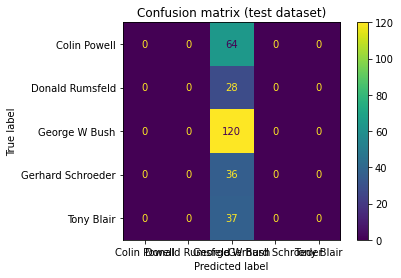

In [28]:
cm = confusion_matrix(yTest, ypred_test, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lfw.target_names)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

In [13]:
classif = svm.SVC(kernel='linear', decision_function_shape='ovr', C=0.1)
classif.fit(bows, yTrain)
print('support vectors: ', classif.support_vectors_)


support vectors:  [[1.00000000e-01 2.55555556e-01 1.44444444e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.94117647e-01 4.80392157e-01 3.43137255e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.86111111e-01 8.88888889e-01 5.55555556e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.01075269e+01 9.17849462e+01 6.48924731e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.84500000e+01 1.43783333e+02 1.01433333e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.20263158e+01 1.13565789e+02 8.01315789e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/

In [17]:
print('prediction class for [2,2]', classif.predict([[10., 10.]]))
print('support vectors: ', classif.support_vectors_)

ValueError: X has 2 features, but SVC is expecting 100 features as input.